## Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.

In [15]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

In [16]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Define Agent

In [17]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [18]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)

In [19]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Define agent Function

In [20]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

Create and Compile the Graph

In [21]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

Display the graph structure

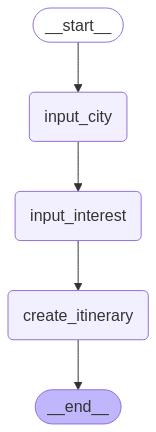

In [22]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

Define the function thats runs the graph

In [23]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [24]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: patna
Please enter your interest for the trip to : patna (comma-separted): 
Your Input: woman
Creating an itinerary for patna based on interests : woman

Final Itinerary: 
As a woman traveling to Patna, here's a suggested day trip itinerary based on popular interests:

* 9:00 AM: Start the day with a visit to the Patna Museum to learn about the city's rich history and culture.
* 11:00 AM: Explore the Mahavir Mandir, a beautiful temple dedicated to Lord Hanuman.
* 1:00 PM: Take a break for lunch at a local restaurant, trying some of the city's famous dishes like Litti Chokha or Jhal Muri.
* 2:30 PM: Visit the Agam Kuan, a historic well with a unique architecture.
* 4:00 PM: Stop by the Patna Sahib Gurudwara, a sacred Sikh shrine that showcases the city's diverse heritage.
* 6:00 PM: End the day with a stroll along the Ganga River, taking in the scenic views and local stree

In [25]:
!pip install gradio

In [26]:
import gradio as gr
from typing import TypedDict, Annotated, List, Optional
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    starting_location: str
    trip_duration: str
    budget: float
    trip_purpose: str
    interests: List[str]
    preferences: List[str]
    travel_dates: str
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)

# Enhanced itinerary prompt to incorporate more details
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an advanced travel assistant. Create a comprehensive day trip itinerary with the following details:
    - Destination: {city}
    - Starting Location: {starting_location}
    - Trip Duration: {trip_duration}
    - Budget: ${budget}
    - Trip Purpose: {trip_purpose}
    - Interests: {interests}
    - Preferences: {preferences}
    - Travel Dates: {travel_dates}

    Provide a detailed, bulleted itinerary that considers all provided parameters. Include:
    1. Transportation options within budget
    2. Activities aligned with interests and purpose
    3. Recommended dining options
    4. Estimated costs for each activity
    5. Any special considerations based on preferences"""),
    ("human", "Create a detailed itinerary for my day trip.")
])

def input_basic_details(
    city: str,
    starting_location: str,
    trip_duration: str,
    budget: float,
    trip_purpose: str,
    state: PlannerState
) -> PlannerState:
    """Process basic trip details."""
    return {
        **state,
        "city": city,
        "starting_location": starting_location,
        "trip_duration": trip_duration,
        "budget": budget,
        "trip_purpose": trip_purpose,
        "messages": state['messages'] + [
            HumanMessage(content=f"City: {city}"),
            HumanMessage(content=f"Starting Location: {starting_location}"),
            HumanMessage(content=f"Trip Duration: {trip_duration}"),
            HumanMessage(content=f"Budget: ${budget}"),
            HumanMessage(content=f"Trip Purpose: {trip_purpose}")
        ]
    }

def input_interests_preferences(
    interests: str,
    preferences: str,
    travel_dates: str,
    state: PlannerState
) -> PlannerState:
    """Process interests, preferences, and travel dates."""
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "preferences": [pref.strip() for pref in preferences.split(',')],
        "travel_dates": travel_dates,
        "messages": state['messages'] + [
            HumanMessage(content=f"Interests: {interests}"),
            HumanMessage(content=f"Preferences: {preferences}"),
            HumanMessage(content=f"Travel Dates: {travel_dates}")
        ]
    }

def create_itinerary(state: PlannerState) -> str:
    """Generate a comprehensive itinerary."""
    response = llm.invoke(itinerary_prompt.format_messages(
        city=state['city'],
        starting_location=state['starting_location'],
        trip_duration=state['trip_duration'],
        budget=state['budget'],
        trip_purpose=state['trip_purpose'],
        interests=", ".join(state['interests']),
        preferences=", ".join(state['preferences']),
        travel_dates=state['travel_dates']
    ))

    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

def travel_planner(
    city: str,
    starting_location: str,
    trip_duration: str,
    budget: float,
    trip_purpose: str,
    interests: str,
    preferences: str,
    travel_dates: str
):
    """Main travel planning function."""
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "starting_location": "",
        "trip_duration": "",
        "budget": 0.0,
        "trip_purpose": "",
        "interests": [],
        "preferences": [],
        "travel_dates": "",
        "itinerary": "",
    }

    # Process inputs
    state = input_basic_details(
        city, starting_location, trip_duration, budget, trip_purpose, state
    )
    state = input_interests_preferences(
        interests, preferences, travel_dates, state
    )

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface with enhanced inputs
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Destination City"),
        gr.Textbox(label="Starting Location"),
        gr.Textbox(label="Trip Duration (e.g., '1 day', '2 days')"),
        gr.Number(label="Budget (in USD)"),
        gr.Textbox(label="Trip Purpose (e.g., leisure, business, cultural exploration)"),
        gr.Textbox(label="Interests (comma-separated)"),
        gr.Textbox(label="Preferences (comma-separated)"),
        gr.Textbox(label="Travel Dates")
    ],
    outputs=gr.Textbox(label="Generated Comprehensive Itinerary"),
    title="Advanced Travel Itinerary Planner",
    description="Enter comprehensive trip details to generate a personalized, detailed day trip itinerary."
)

# Launch the Gradio application
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://02b8992ff6c40c16ca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
